# Weighted RMSE objective for optimization

This notebook describes the motivation and arrival at the weighted RMSE heuristic  for assessing goodness of fit when optimizing for a particular input

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from json import load

Use the supra threshold parameter file

In [2]:
in_fname = "param/ERPYesSupra-3trial.json"
with open(in_fname) as json_data:
    params_input = load(json_data)


Plot the probability distribution functions for each input given the mean and standard deviation from the parameter file. This shows where changes to the contribution occur.

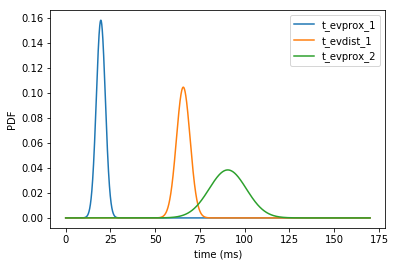

In [3]:
num_step = int(params_input['tstop'] / params_input['dt'] + 1)
times = np.linspace(0, params_input['tstop'], num_step)
for input_name in ['t_evprox_1', 't_evdist_1', 't_evprox_2']:
    mu = params_input[input_name]
    sigma = params_input['sigma_%s'%input_name]
    plt.plot(times, stats.norm.pdf(times, mu, sigma), label=input_name)
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("PDF")
plt.show()
plt.close()

## Developing an index of influence in time

A basic assumption of our optimization procedure is that the dipole at time t can only be affected by inputs previous to t. Since the inputs are modeled as a gaussian process, the influence from input A increases according to its CDF as a function of time (~1.0 would be full influence). So if were were interested in the combined influence, we could model it as the sum of each input's CDF.

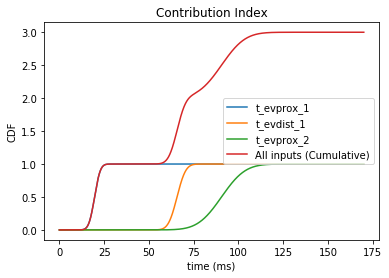

In [4]:
inputs = ['t_evprox_1', 't_evdist_1', 't_evprox_2']
num_step = int(params_input['tstop'] / params_input['dt'] + 1)
cdf = {}
total_cdf = np.zeros(num_step)
for input_name in inputs:
    mu = params_input[input_name]
    sigma = params_input['sigma_%s'%input_name]
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x = np.linspace(0, params_input['tstop'], num_step)

    cdf[input_name] = stats.norm.cdf(x, mu, sigma)
    total_cdf += cdf[input_name]
    plt.plot(x, cdf[input_name], label=input_name)
plt.plot(x, total_cdf, label="All inputs (Cumulative)")
plt.legend()
plt.title("Contribution Index")
plt.xlabel("time (ms)")
plt.ylabel("CDF")
plt.show()
plt.close()

## Unique contribution

However, for the sequential authorization procedure we are optimizing the parameters for one input at a time.  We assume the other inputs with distributions coming later will have an influence that progressively diminishes the influence of the input current being optimized. So, rather than the cumulative influence, we are more interested in the optimized input's unique contribution to the waveform. By subtracting the influence of following inputs, we obtain an index of unique contribution.

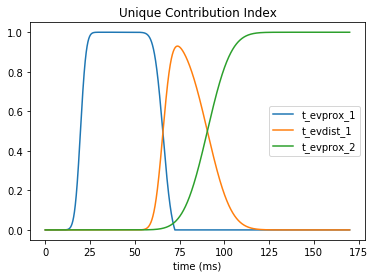

In [5]:
weight={}
for input_name in inputs:
    weight[input_name] = cdf[input_name].copy()
    for other in inputs:
        if other is input_name:
            # don't subtract our own cdf
            continue
        elif params_input[other] < params_input[input_name]:
            # skip earlier inputs
            continue
        else:
            weight[input_name] -= cdf[other]
    weight[input_name] = np.clip(weight[input_name], a_min=0, a_max=None)
    plt.plot(x, weight[input_name], label=input_name)
plt.legend()
plt.xlabel("time (ms)")
plt.title("Unique Contribution Index")
plt.show()
plt.close()

A naive way of scoring an input's contribution to the fit of data could be implemented by assingning a weight to each time point's residual squared and calculating the root of the mean (weighted RMSE).

However, the narrow overlap between `t_evprox_1` and `t_evdist_1`, for example, means that any changes made when optimizing `t_evprox_1` could be disruptive to `t_evdist_1`, but receive a high weighted RMSE score befores moving on. This may be a poor set of initial values for optimizing subsequent inputs (they may not be able to compensate) and we can think of this as increasing the likelihood of finding an alternate, but less desirable local-minimum as optimization proceeds.

## Considering (limited) downstream effects

We can increase `t_evprox_1`'s concern with regions subsequently optimized by not fully subtracting subsequent CDFs.  Instead a decay factor can be assigned that gives more consideration to inputs closely following (less opportunity to compensate) than those following much later. 

The decay factor should be scaled according to the percentage of simulation time from one input to the next. It also needs a coefficient, which was chosen subjectively, but meets this qualitative requirement: 
 * `t_evprox_1`  needs to consider the region whre immediately subsequent `t_evdist_1`'s unique contribution index (shown in previous plot) is above 0 and `t_evdist_1`  needs to consider the region where `t_evprox_2`'s unique contribution index is above 0 (the remainder of the simulation).

Subtracting cdf of t_evdist_1 from t_evprox_1 with decay_factor=0.4334
Subtracting cdf of t_evprox_2 from t_evprox_1 with decay_factor=0.6672
Subtracting cdf of t_evprox_2 from t_evdist_1 with decay_factor=0.2338


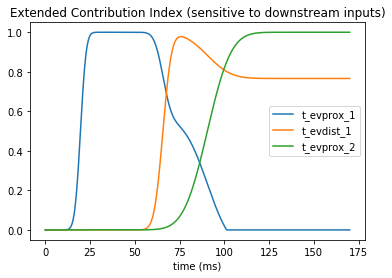

In [6]:
weights={}
decay_multiplier = 1.6
for input_name in inputs:
    weights[input_name] = cdf[input_name].copy()
    for other in inputs:
        cont = False
        if other is input_name:
            # don't subtract our own cdf
            continue
        if params_input[other] < params_input[input_name]:
            continue
        else:
            decay_factor = decay_multiplier*(params_input[other]-params_input[input_name])/params_input['tstop']
            print("Subtracting cdf of %s from %s with decay_factor=%.4f" % \
                  (other, input_name, decay_factor))
            weights[input_name] -= (cdf[other]*decay_factor)
    weights[input_name] = np.clip(weights[input_name], a_min=0, a_max=1)
    plt.plot(x, weights[input_name], label=input_name)
plt.legend()
plt.xlabel("time (ms)")
plt.title("Extended Contribution Index (sensitive to downstream inputs)")
plt.show()
plt.close()

## Weighted RMSE

We are starting with RMSE which is a measure of the time series differences between the dipole signal generated by HNN and the observed signal. Based on the time series application of RMSE [from Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation), HNN's RMSE measure can be defined as
\begin{align}
\operatorname{RMSE}= \sqrt{\frac{\sum_{t=1}^T (x_{1,t} - x_{2,t})^2}{T}},
\end{align}

Where $t$ is the current time, from $1$ to $T$, and $x_{1,t}$ is the HNN prediction at $t$ and $x_{2,t}$ is the observed data point.

By attempting to minimize the RMSE, we are minimizing the variance and the bias. However, not all points in time are equally important when trying to find the best fit due to *only* one input. The Extended Contribution Index (ECI) that is sensititive to downstream inputs is a proposed method for determining weights of each time point. In order to calculated a weighted RMSE we are looking for a weighted calculation MSE of our HNN estimator. Without a clear definition of the weighted RMSE with respect to time series data, the field of geochronology provides an [example of calculating the biased weighted estimator of variance](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic#Geochronology).
\begin{align}
\sigma^2 = \frac{\sum_{i=1}^N w_i (x_i - \overline{x}^*)^2}{\sum_{i=1}^N w_i}
\end{align}

We can relate our use of RMSE for compaing HNN-generated signals to quantifying the error of a biased estimator (HNN model being the estimator). Adapting above to the time series comparison of two signals, we define weighted RMSE for input $k$ as
\begin{align}
\operatorname{wRMSE_k} = \sqrt{\frac{\sum_{t=0}^T w_{k,t} (x_{1,t} - x_{2,t})^2}{\sum_{t=0}^N w_{k,t}}},
\end{align}
where $w_{k,t}$ is the weight for input $k$ at time $t$, from $0$ to $T$. 
